In [43]:
from commonFunctions import *
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


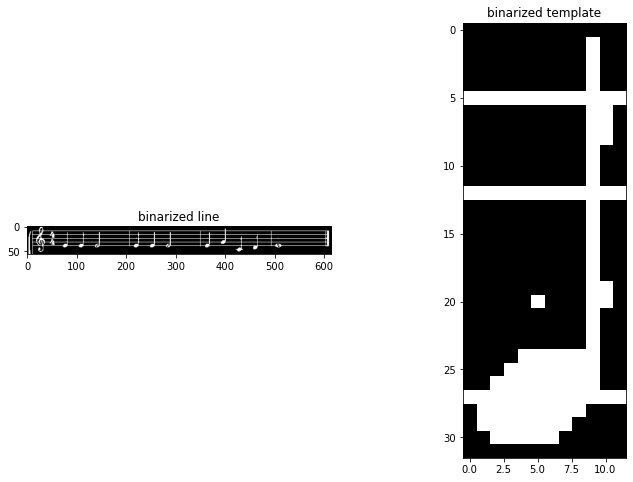

(57, 615) (32, 12)


In [44]:
# load line & template as gray images and binarize them
img = (cv.imread("imgs/line.png",0)).astype(np.uint8)
template = (cv.imread("imgs/template.png",0)).astype(np.uint8)
img = (img <= threshold_otsu(img)).astype(np.uint8)
template = (template <= threshold_otsu(template)).astype(np.uint8)
show_images([img,template],["binarized line","binarized template"])
print(img.shape,template.shape)

[0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 1 0 0 0
 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
27


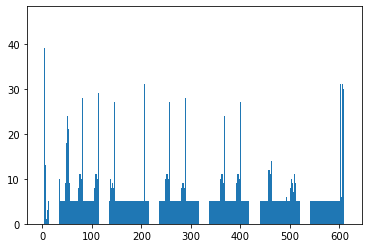

In [46]:
# perform vertical-histogram-projection and display it
his = cv.reduce(img,0,cv.REDUCE_SUM,dtype=cv.CV_32S)[0]
print(img[:,400])
print(his[400])
plt.bar(np.arange(len(his)),his)
plt.show()